<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/RNN_for_Sequence2SequenceForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exploring Recurrent Neural Networks with Self-Attention Mechanisms**

### **0) Introduction**

####_This notebook serves as a comprehensive exploration of Recurrent Neural Networks (RNNs) enhanced with self-attention mechanisms. Through this journey, we delve into various RNN architectures, including the Gate Recurrent Unit (GRU), Long Short-Term Memory (LSTM) and Legendre Memory Unit (LMU) networks, augmented with self-attention mechanisms for improved performance in sequence modeling tasks._  


  

---


###**List of Contents:**  

###**Import**

>**1.0** Cleaning Runtime Environment.  
**1.1** Importing necessary libraries and dependencies.  
**1.2** Setting up the environment.  
  
###**Generate Data**

>**2.0** Generating synthetic data for experimentation.

**Gate Recurrent Unit Neural Network**

>**3.0** Implementation and training of a GRU-based neural network.  
>**3.1** Evaluation and visualization of results.

###**Self-Attention - Long Short Term Memory Neural Network**

>**4.0** Implementation and training of an LSTM neural network with self-attention.  
>**4.1** Evaluation and visualization of results.

###**Self-Attention - Gate Recurrent Unit Legendre Memory Unit Neural Network**

>**5.0** Implementation and training of a GRU-Legendre Memory Unit (LMU)  
  network with self-attention.  
>**5.1** Showing Legendre polynomials ued in the LMU network.  
>**5.2** Evaluation and visualization of results.    

###**Overall Comparison**

>**6.0** Implementation and training of a Multi-Output with Custum Loss   
  network.   
>**6.1** Evaluation and visualization of results.

###**Multi-Output Custom Loss - Gate Recurrent Unit Unit Neural Network**

>**7.0** Data Generation for Multi-Output application.   
>**7.1** Implementation and training of a Multi-Output with Custum Loss   
  network.   
>**7.2** Evaluation and visualization of results.



---


####**CORE DEPENDENCIES:**
> numpy: 1.25.2  
tensorflow: 2.15.0  
pandas: 1.5.3  
keras: 2.15.0  
scipy: 1.11.4  
sklearn: 1.4.1  
matplotlib: 3.7.1





---



##__1) Import__

In [ ]:
# @title #####__1.0 Import__

locals().clear()
globals().clear()

In [ ]:
# @title #####__1.1 Import__

%%capture

!pip install pydot
!pip install graphviz
!apt-get install graphviz

! git clone keras_self_attention
! git clone https://github.com/nengo/keras-lmu.git

! pip install keras_self_attention
! pip install keras_lmu


In [ ]:
# @title #####__1.2 Import__

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils  import plot_model
from tensorflow.keras.layers import Dense, GRU, LSTM, SimpleRNNCell, Dropout, Flatten

import keras
import keras_lmu
import keras.backend as K
from keras.layers import Lambda
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

from keras.models import Model

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.special import legendre

seed=89
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)
init=tf.keras.initializers.GlorotNormal(seed=seed)
keras.utils.set_random_seed(seed=seed)

def lr_schedule(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * np.exp(-0.001)


#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#import os
#packages = [
#    'numpy',
#    'tensorflow',
#    'pandas',
#    'keras',
#    'scipy',
#    'sklearn',
#    'matplotlib'
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
#numpy: 1.23.5
#pysindy: 1.7.5
#pandas: 1.5.3
#_______________________________________________________________________________


##__2) Generate Data__

In this section, synthetic data will be generated solely to properly operate the models. They will then be formatted to be processable by the RNN blocks.

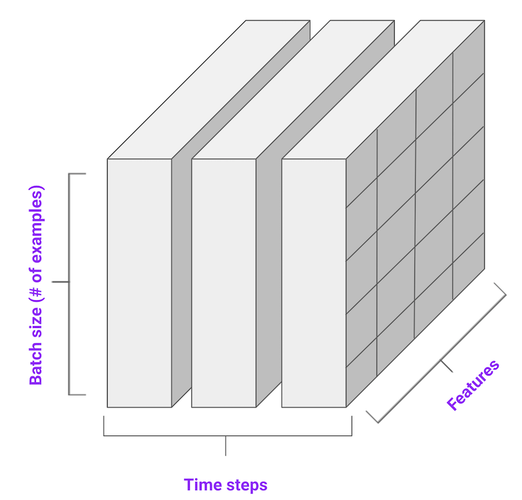  

from: https://www.bpesquet.fr/mlhandbook/algorithms/recurrent_neural_networks.html

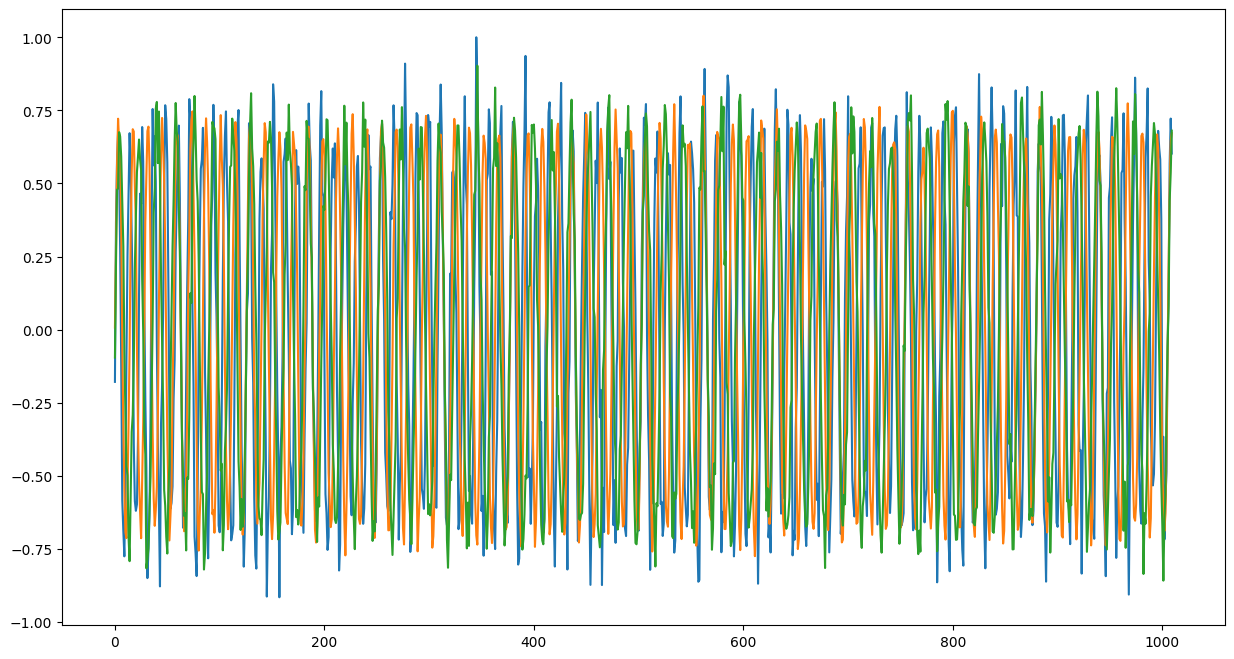

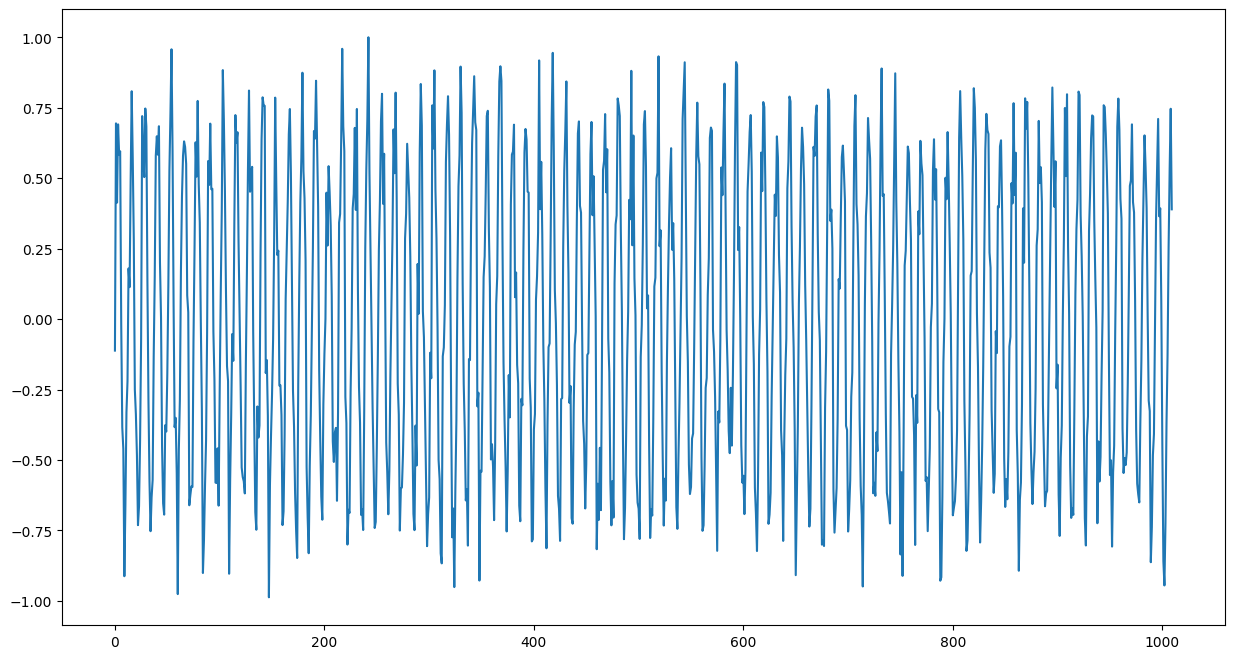

X_train shape (200, 10, 3)
y_train shape (200,)


In [ ]:
# @title ####__2.0 Generate Data__

def generate_time_series(num_samples, n_steps):
    # Generate some dummy data with trends
    time = np.arange(num_samples + n_steps)
    trend_1 = np.sin(0.55 * time) + np.random.randn(num_samples + n_steps) * 0.15 # Sinusoidal trend for feature_1
    trend_2 = np.sin(0.45 * time) + np.random.randn(num_samples + n_steps) * 0.05 # Sinusoidal trend for feature_2
    trend_3 = np.sin(0.35 * time) + np.random.randn(num_samples + n_steps) * 0.1  # Sinusoidal trend for feature_3
    series = np.column_stack((trend_1, trend_2, trend_3))
    series = series / np.max(series)

    # Generating target data for feature_4
    target_trend = np.sin(0.5 * time)
    target_noise = np.random.randn(num_samples + n_steps) * 0.2
    target_series = target_trend + target_noise
    target_series = target_series / np.max(target_series)
    series = np.column_stack((series, target_series))

    plt.figure(figsize=(15,8))
    plt.plot(series[:, 0])
    plt.plot(series[:, 1])
    plt.plot(series[:, 2])
    plt.show()
    plt.figure(figsize=(15,8))
    plt.plot(target_series)
    plt.show()
    return series

# Generate time series data
num_samples = 1000  # Number of samples
n_steps = 10       # Number of past time steps
series = generate_time_series(num_samples, n_steps)

# Prepare data for LSTM
def prepare_data(series, n_steps, n_features):
    X, y = [], []
    for i in range(len(series)-n_steps):
        end_ix = i + n_steps
        seq_x, seq_y = series[i:end_ix, :-1], series[end_ix-1, -1]  # Input features and target
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_features = 3  # Number of input features (excluding the target)
X, y = prepare_data(series, n_steps, n_features)

# Reshape data for LSTM
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Splitting data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
print('X_train shape', np.shape(X_train))
print('X_test shape' , np.shape(X_test))
y_train, y_test = y[:train_size], y[train_size:]
print('y_train shape', np.shape(y_train))
print('y_test shape',  np.shape(y_test))


##__3) Gate Recurrent Unit (GRU)__

GRU (Gated Recurrent Unit):

GRU is a type of RNN architecture introduced by Cho et al. in 2014. It is similar to LSTM but has a simplified structure.
In a standard GRU unit, there are two gates: the update gate and the reset gate.
The update gate controls how much of the past information should be passed along to the future, while the reset gate decides how much of the past information to forget.
The update and reset gates are computed based on the input at the current time step and the hidden state from the previous time step.
GRUs are computationally more efficient compared to LSTMs as they have fewer parameters and computations.
However, GRUs may not be as effective as LSTMs in capturing long-term dependencies in some scenarios due to their simpler structure.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 30)            3150      
                                                                 
 gru_1 (GRU)                 (None, 20)                3120      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 6291 (24.57 KB)
Trainable params: 6291 (24.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/200
40/40 [==============================] - 8s 53ms/step - loss: 0.2704 - val_loss: 0.2708 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 1s 15ms/step - loss: 0.2673 - val_loss: 0.2675 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 1s

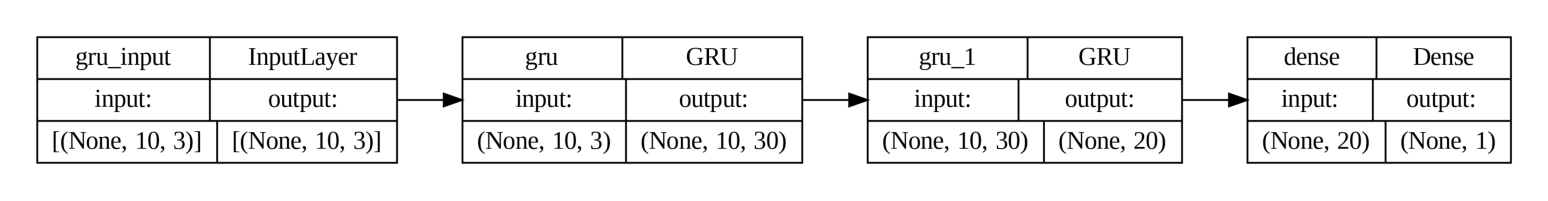

In [ ]:
# @title ####__3.0 Gate Recurrent Unit Neural Network__


### GRU ###

# Define GRU model
model = Sequential([
    GRU(30,   activation='tanh', input_shape=(n_steps, n_features), kernel_initializer=GlorotUniform(seed=seed), return_sequences=True),
    #SeqSelfAttention(attention_activation='tanh', kernel_initializer=GlorotUniform(seed=seed)), #sum method
    GRU(20,   activation='tanh', kernel_initializer=GlorotUniform(seed=seed), return_sequences=False),

    Dense(1,  activation='linear', kernel_initializer=GlorotUniform(seed=seed))
])

# Compile model
optimizer = Adam(learning_rate=0.001)
lr_scheduler = LearningRateScheduler(lr_schedule)
model.compile(optimizer=optimizer, loss='mse')
print(model.summary())

# Train model
history_GRU = model.fit(X_train, y_train, epochs=200, batch_size=n_steps*2, validation_data=(X_test, y_test), callbacks=[lr_scheduler])
model.save("GRUmodel.keras")
plot_model(model, to_file='GRUmodel_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=300)
plt.figure(dpi=300)
img = plt.imread('GRUmodel_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()


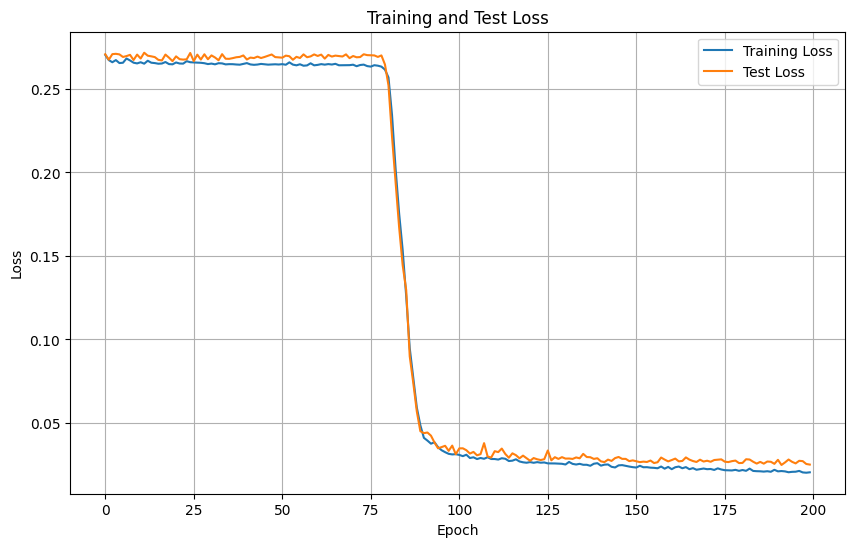

7/7 [==============================] - 1s 5ms/step
Test MSE: 0.025101711922812343


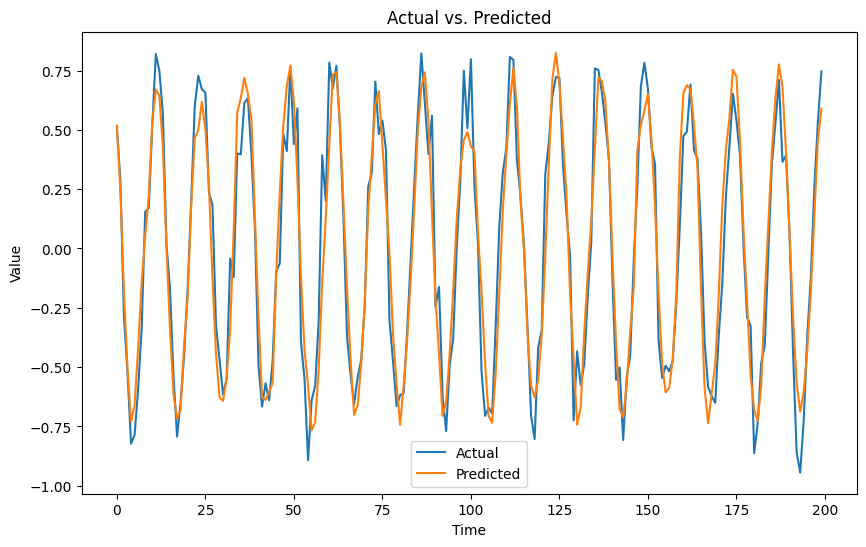

In [ ]:

# @title #####__3.1 Plot Results__

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#______________________________________________________________________________
# Make predictions on test data
y_pred = model.predict(X_test)
out_GRU = y_pred

mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0: 1000], label='Actual')
plt.plot(y_pred[0: 1000], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

##__4) Self Attenction Long Short Term Memory (LSTM)__

LSTM (Long Short-Term Memory):

LSTM is a type of RNN architecture introduced by Hochreiter and Schmidhuber in 1997 to address the vanishing gradient problem.
LSTM units contain a cell state, which acts as a memory unit that can store information over long sequences.
The cell state is regulated by three gates: the input gate, the forget gate, and the output gate.
The input gate controls how much new information should be added to the cell state, the forget gate decides what information to discard from the cell state, and the output gate determines the output of the LSTM unit.
LSTMs are effective in capturing long-range dependencies in sequences and are widely used in various applications such as natural language processing, speech recognition, and time series prediction.

Self-Attention Layer:

The self-attention mechanism is a key component of transformer architectures, which have achieved state-of-the-art performance in various natural language processing tasks.
In a self-attention layer, each input element (e.g., word embedding in a sentence) computes a weighted sum of all other elements based on their similarities.
The similarity between input elements is determined using a learned attention mechanism, which assigns higher weights to more relevant elements and lower weights to less relevant ones.
Self-attention allows the model to focus more on important parts of the input sequence while ignoring irrelevant or less important parts, enabling it to capture long-range dependencies and context more effectively.
Self-attention layers have revolutionized natural language processing tasks such as machine translation, text summarization, and sentiment analysis, leading to significant improvements in performance compared to traditional recurrent neural network architectures.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            4080      
                                                                 
 seq_self_attention (SeqSel  (None, 10, 30)            1861      
 fAttention)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 20)                4080      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 10042 (39.23 KB)
Trainable params: 10042 (39.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
40/40 [==============================] - 5s 41ms/step - loss: 0.2682

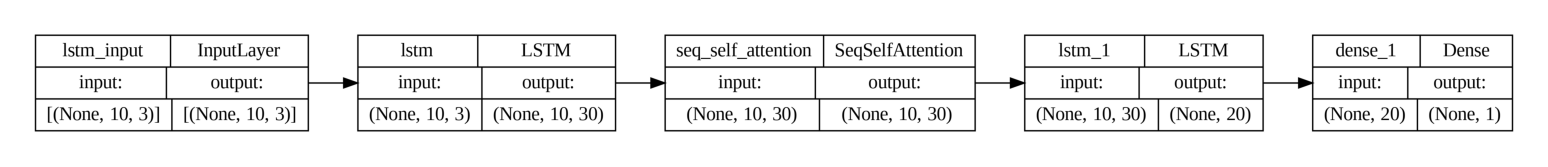

In [ ]:
# @title ####__4.0 Self Attenction - Long Short Term Memory Neural Network__

### STANDARD LSTM ###

# Define LSTM model
model = Sequential([
    LSTM(30, activation='tanh', input_shape=(n_steps, n_features), kernel_initializer=GlorotUniform(seed=seed), return_sequences=True),
    SeqSelfAttention(units=30, attention_activation='tanh', kernel_initializer=GlorotUniform(seed=seed)), #sum method
    LSTM(20, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), return_sequences=False),

    Dense(1,  activation='linear', kernel_initializer=GlorotUniform(seed=seed))
])

# Compile model
optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001
lr_scheduler = LearningRateScheduler(lr_schedule)
model.compile(optimizer=optimizer, loss='mse')
print(model.summary())

# Train model
history_LSTM = model.fit(X_train, y_train, epochs=50, batch_size=n_steps*2, validation_data=(X_test, y_test), callbacks=[lr_scheduler])
model.save("LSTMmodel.keras")
plot_model(model, to_file='LSTMmodel_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=300)
plt.figure(dpi=300)
img = plt.imread('LSTMmodel_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()


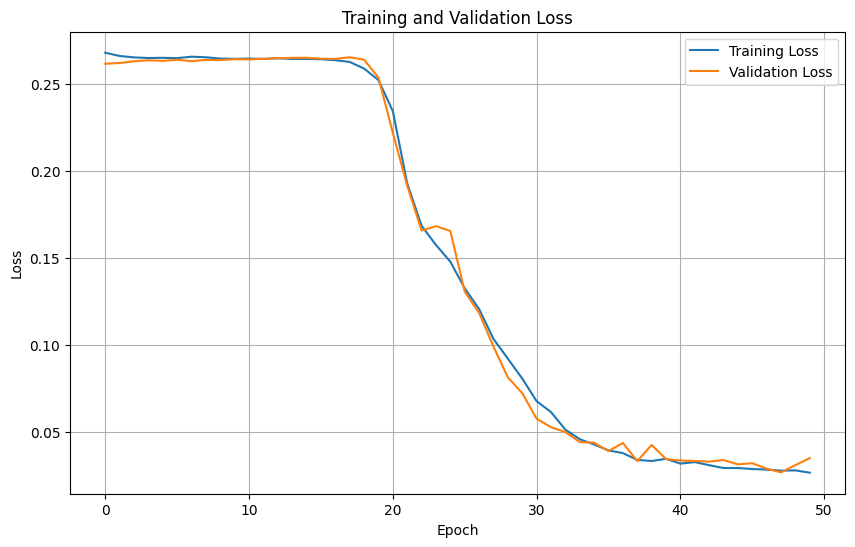

7/7 [==============================] - 1s 7ms/step
Test MSE: 0.035027034027829126


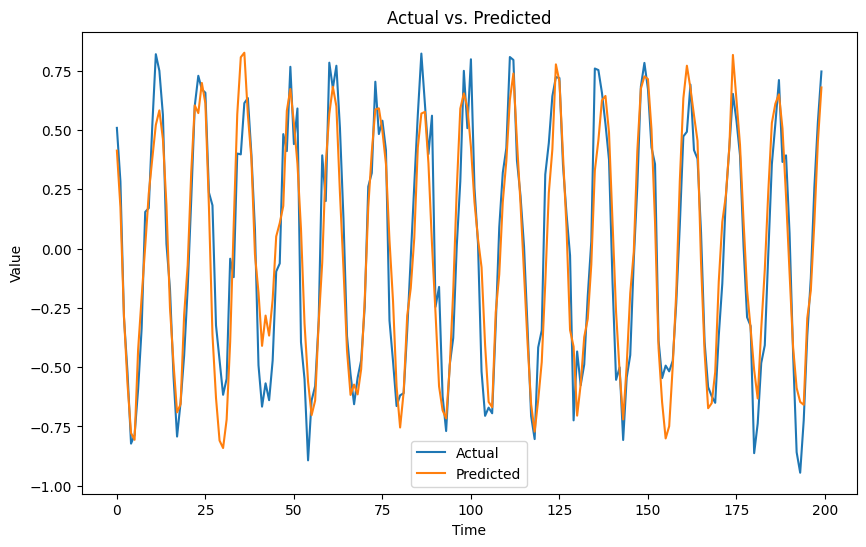

In [ ]:
# @title #####__4.1 Plot Results__

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#______________________________________________________________________________
# Make predictions on test data
y_pred = model.predict(X_test)
out_LSTM = y_pred

# Calculate evaluation metrics (e.g., Mean Squared Error)

mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0: 1000], label='Actual')
plt.plot(y_pred[0: 1000], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


##__5) Self Attenction Hybrid GRU-Legendre Memory Unit (LMU)__

LMU (Legendre Memory Units):

LMU is a novel type of neural network architecture introduced by Voelker et al. in 2020.
It utilizes Legendre polynomials, which are a set of orthogonal polynomials, to model temporal dynamics in sequential data.
Unlike traditional RNNs, LMUs do not rely on explicit gating mechanisms but instead use a fixed set of mathematical operations based on Legendre polynomials to process temporal sequences.
LMUs can capture long-term dependencies in sequential data while maintaining computational efficiency, making them suitable for applications requiring processing of large-scale temporal data.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 gru_2 (GRU)                 (None, 10, 30)            3150      
                                                                 
 seq_self_attention_1 (SeqS  (None, 10, 30)            1861      
 elfAttention)                                                   
                                                                 
 lmu (LMU)                   (None, 20)                5720      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 10752 (42.00 KB)
Trainable params: 10752 (42.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

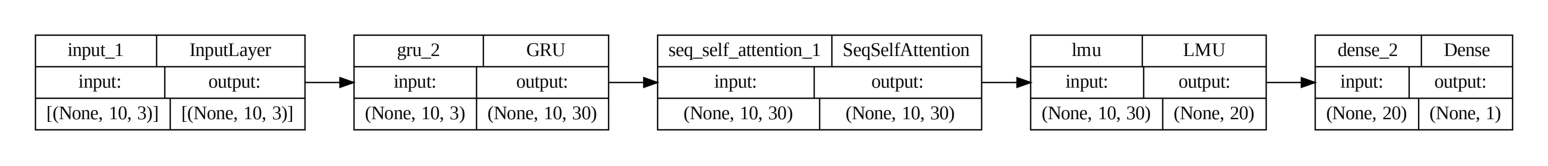

In [ ]:
# @title ####__5.0 Self Attenction - Gate Recurrent Unit Legendre Memory Unit Neural Network__

### LMU ###

lmu_layer = keras_lmu.LMU(
       memory_d=10,
       order=25,
       theta=100,
       hidden_cell=tf.keras.layers.SimpleRNNCell(units=20),
   )

inputs  = Input((n_steps, n_features))
GRUs    = GRU(30, activation='tanh', input_shape=(n_steps, n_features), kernel_initializer=GlorotUniform(seed=seed), return_sequences=True)(inputs)
SA_lyr  = SeqSelfAttention(units=30, attention_activation='tanh', kernel_initializer=GlorotUniform(seed=seed))(GRUs) #sum method
LMUs    = lmu_layer(SA_lyr)
outputs = Dense(1)(LMUs)

model = Model(inputs=inputs, outputs=outputs)

# Compile model
optimizer = Adam(learning_rate=0.001)  # Set learning rate to 0.001
lr_scheduler = LearningRateScheduler(lr_schedule)
model.compile(optimizer=optimizer, loss='mse')
batch_size = n_steps
input_shape = (n_steps, n_features)
model.build(input_shape=(batch_size,) + input_shape)
print(model.summary())

# Train model
history_LMU = model.fit(X_train, y_train, epochs=25, batch_size=n_steps*2, validation_data=(X_test, y_test), callbacks=[lr_scheduler])
model.save("LMUmodel.keras")
plot_model(model, to_file='LMUmodel_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=300)
plt.figure(dpi=300)
img = plt.imread('LMUmodel_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()



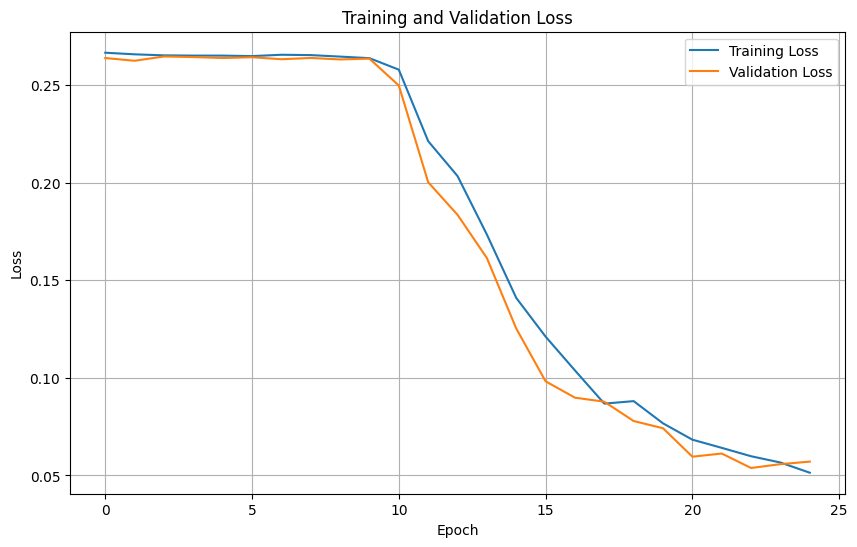

7/7 [==============================] - 1s 6ms/step
Test MSE: 0.05707964556481475


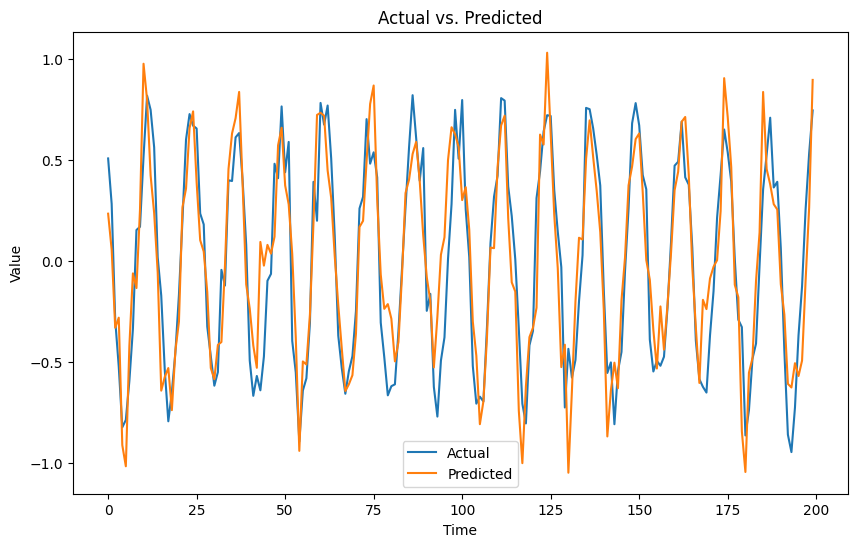

In [ ]:
# @title #####__5.1 Plot Results__

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_LMU.history['loss'], label='Training Loss')
plt.plot(history_LMU.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#______________________________________________________________________________
# Make predictions on test data
y_pred = model.predict(X_test)
out_LMU = y_pred

# Calculate evaluation metrics (e.g., Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

plt.figure(figsize=(10, 6))
plt.plot(y_test[0: 1000], label='Actual')
plt.plot(y_pred[0: 1000], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

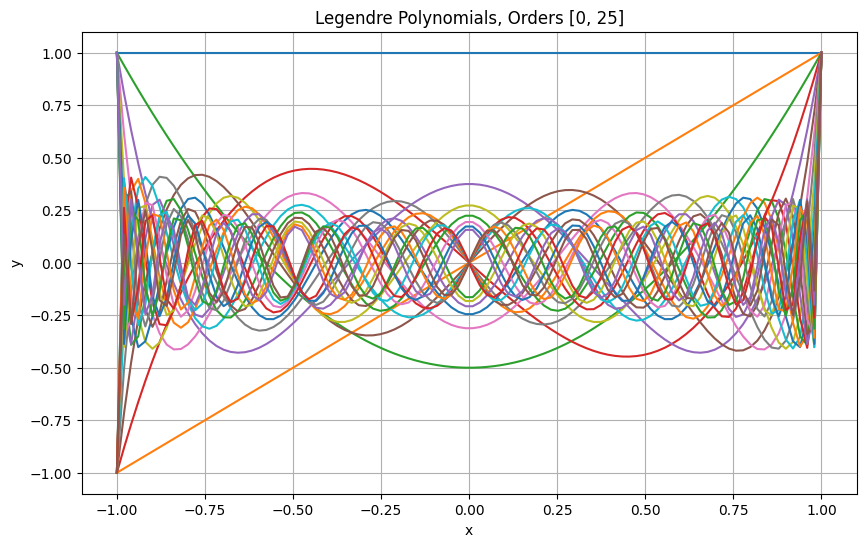

In [ ]:
# @title #####__5.2 Legendre Polynomial__

# Generate Legendre polynomials
order_poly = 25  # Change this to match the LMU memory_d value
x_values = np.linspace(-1, 1, 100)
legendre_polynomials = [legendre(i)(x_values) for i in range(order_poly + 1)]

plt.figure(figsize=(10, 6))
for i, poly in enumerate(legendre_polynomials):
    plt.plot(x_values, poly, label=f"Legendre Polynomial {i}")

plt.title(f"Legendre Polynomials, Orders [0, {order_poly}]" )
plt.xlabel("x")
plt.ylabel("y")
#plt.legend()
plt.grid(True)
plt.show()

##__6) Comparison__  

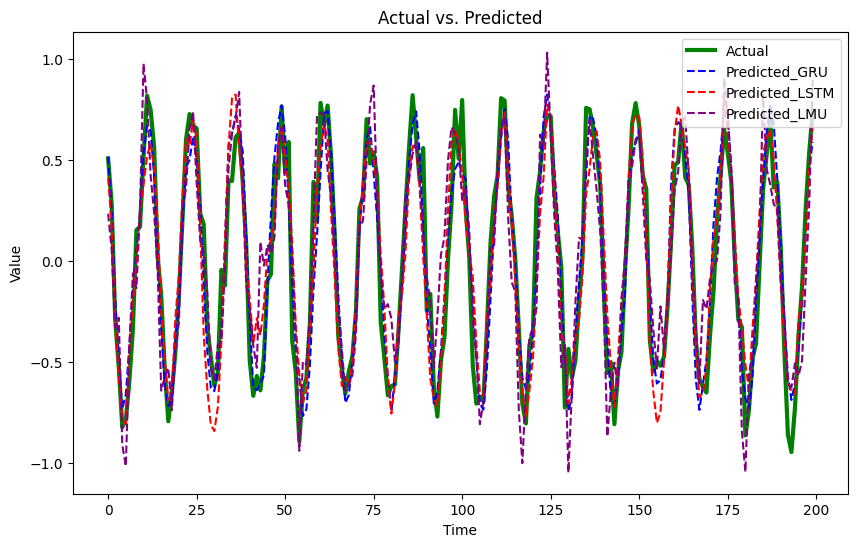

In [ ]:
# @title ####__6.0 Overall Comparison__


# OVERALL COMPARISON

plt.figure(figsize=(10, 6))
plt.plot(y_test[0: 1000],   color='green',  linestyle='solid',  linewidth=3, label='Actual')
plt.plot(out_GRU[0: 1000],  color='blue',   linestyle='dashed', linewidth=1.5, label='Predicted_GRU')
plt.plot(out_LSTM[0: 1000], color='red',    linestyle='dashed', linewidth=1.5, label='Predicted_LSTM')
plt.plot(out_LMU[0: 1000],  color='purple', linestyle='dashed', linewidth=1.5, label='Predicted_LMU')
plt.legend(loc='upper right')
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

##__7) Multi-Output with Custom Loss Network__

Multi-Output Network:

A multi-output neural network is a type of neural network architecture where the model has multiple output layers, each responsible for predicting a different target variable.
This architecture is commonly used when a single model needs to perform multiple tasks simultaneously or predict multiple related variables.
Each output layer may have its own activation function and loss function, depending on the nature of the prediction task and the desired output format.

Custom Loss Functions:

A loss function quantifies how well the model's predictions match the true target values during training. It is a crucial component of the training process, as it guides the optimization algorithm to update the model's parameters.
In a multi-output network, different output branches may have different loss functions tailored to the specific characteristics of the predicted variables.
Custom loss functions can be designed based on domain knowledge, task requirements, or specific properties of the target variables.

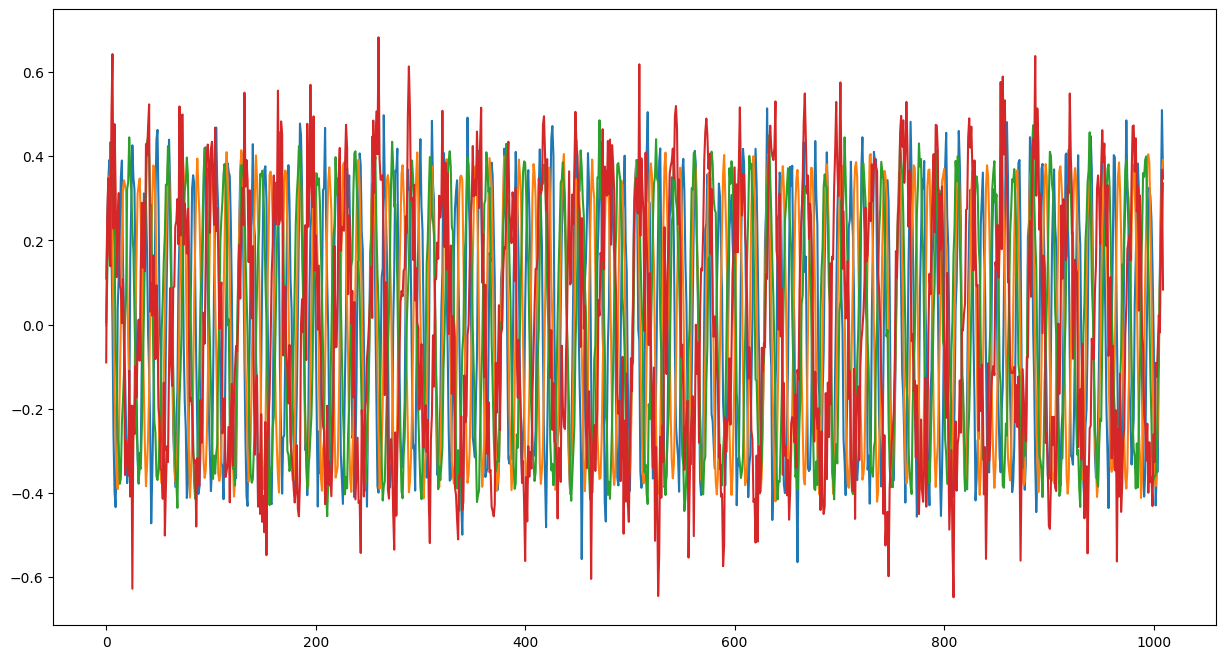

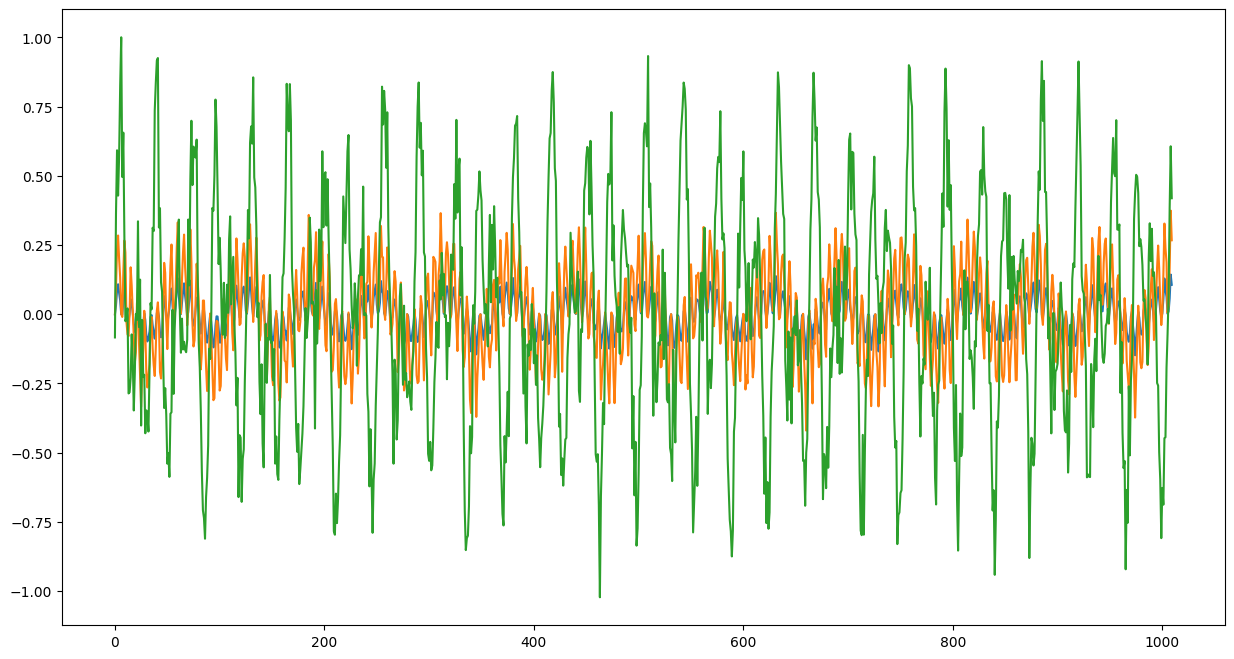

X_train shape (800, 10, 4)
X_test shape (200, 10, 4)
y_train shape (800, 3)
y_test shape (200, 3)


In [ ]:
# @title ####__7.0 Generate Data for Multi-Output Net__

def generate_time_series(num_samples, n_steps):
    # Generate some dummy data with trends
    time = np.arange(num_samples + n_steps)
    trend_1 = np.sin(0.55 * time) + np.random.randn(num_samples + n_steps) * 0.15 # Sinusoidal trend for feature_1
    trend_2 = np.sin(0.45 * time) + np.random.randn(num_samples + n_steps) * 0.05 # Sinusoidal trend for feature_2
    trend_3 = np.sin(0.35 * time) + np.random.randn(num_samples + n_steps) * 0.1  # Sinusoidal trend for feature_3
    trend_4 = np.sin(0.2  * time) + np.random.randn(num_samples + n_steps) * 0.3  # Sinusoidal trend for feature_4

    # Generating target data
    target_trend_1 = trend_1 * (0.3 * trend_2)
    target_trend_2 = trend_1 * np.tanh(trend_2)
    target_trend_3 = trend_3 + trend_4

    series = np.column_stack((trend_1, trend_2, trend_3, trend_4, target_trend_1, target_trend_2, target_trend_3))
    series = series / np.max(series)

    plt.figure(figsize=(15,8))
    plt.plot(series[:, 0])
    plt.plot(series[:, 1])
    plt.plot(series[:, 2])
    plt.plot(series[:, 3])
    plt.show()
    plt.figure(figsize=(15,8))
    plt.plot(series[:, 4])
    plt.plot(series[:, 5])
    plt.plot(series[:, 6])
    plt.show()
    return series

# Generate time series data
num_samples = 1000  # Number of samples
n_steps = 10       # Number of past time steps
series = generate_time_series(num_samples, n_steps)

# Prepare data for LSTM
def prepare_data(series, n_steps, n_features):
    X, y = [], []
    for i in range(len(series)-n_steps):
        end_ix = i + n_steps
        seq_x, seq_y = series[i:end_ix, : n_features], series[end_ix-1, n_features :]  # Input features and target
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_features = 4  # Number of input features (excluding the target)
X, y = prepare_data(series, n_steps, n_features)

# Reshape data for LSTM
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Splitting data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
print('X_train shape', np.shape(X_train))
print('X_test shape' , np.shape(X_test))
y_train, y_test = y[:train_size], y[train_size:]
print('y_train shape', np.shape(y_train))
print('y_test shape',  np.shape(y_test))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 10, 4)]              0         []                            
                                                                                                  
 commonGRU (GRU)             (None, 10, 10)               420       ['input[0][0]']               
                                                                                                  
 GRU3.0 (GRU)                (None, 10, 5)                135       ['input[0][0]']               
                                                                                                  
 GRU1.0 (GRU)                (None, 5)                    225       ['commonGRU[0][0]']           
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


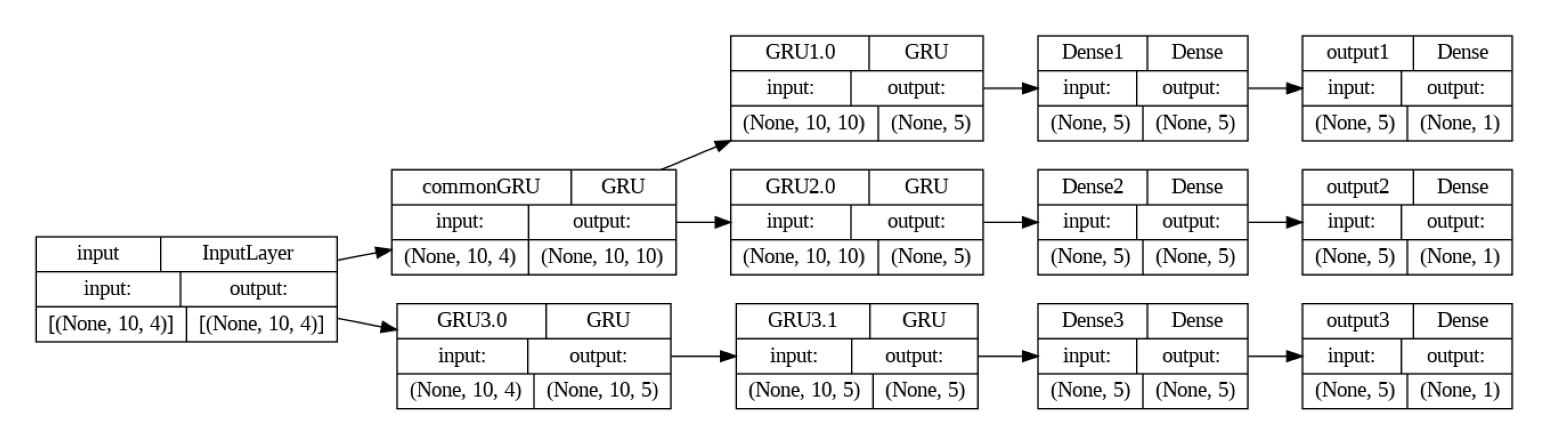

In [ ]:
# @title ####__7.1 Multi-Output Custom Loss Network__

from keras.models import Model
from keras.layers import Input, GRU, LSTM, Dense, Concatenate
from keras.initializers import GlorotUniform
seed = 89

import keras.backend as K

def custom_loss1(y_true, y_pred):
    return K.mean(K.abs(y_true[:, 0] - tf.squeeze(y_pred) + 1e-10), axis=-1)

def custom_loss2(y_true, y_pred):
    return K.mean(K.abs(y_true[:, 1] - tf.squeeze(y_pred) + 1e-10), axis=-1)

def custom_loss3(y_true, y_pred):
    loss_3 = (K.mean(K.abs(y_true[:, 2] - tf.squeeze(y_pred) + 1e-10), axis=-1) +
              K.mean(K.square(y_true[:, 2] - tf.squeeze(y_pred) + 1e-10), axis=-1)
              ) / 2
    return loss_3


input_layer = Input(shape=(n_steps, n_features), name='input')

common_branch = GRU(10, activation='elu', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, return_sequences=True, name='commonGRU')(input_layer)

branch1  = GRU(  5, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, return_sequences=False, name='GRU1.0')(common_branch)
branch11 = Dense(5, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense1')(branch1)

branch2  = GRU(  5, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, return_sequences=False, name='GRU2.0')(common_branch)
branch22 = Dense(5, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense2')(branch2)

branch3  = GRU(  5, activation='elu',  kernel_initializer=GlorotUniform(seed=seed), use_bias=False, return_sequences=True,  name='GRU3.0')(input_layer)
branch32 = GRU(  5, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, return_sequences=False, name='GRU3.1')(branch3)
branch33 = Dense(5, activation='tanh', kernel_initializer=GlorotUniform(seed=seed), use_bias=False, name='Dense3')(branch32)

output1 = Dense(1, activation='linear', use_bias=False, name='output1')(branch11)
output2 = Dense(1, activation='linear', use_bias=False, name='output2')(branch22)
output3 = Dense(1, activation='linear', use_bias=False, name='output3')(branch33)


model = Model(inputs=input_layer, outputs=[output1, output2, output3])

model.compile(optimizer='adam',
              loss={'output1': custom_loss1, 'output2': custom_loss2, 'output3': custom_loss3})

print(model.summary())

# Train model
history_GRU = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test))
model.save("MultiOut_model.h5")
plot_model(model, to_file='MultiOut_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')
plt.figure(dpi=300)
img = plt.imread('MultiOut_model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()


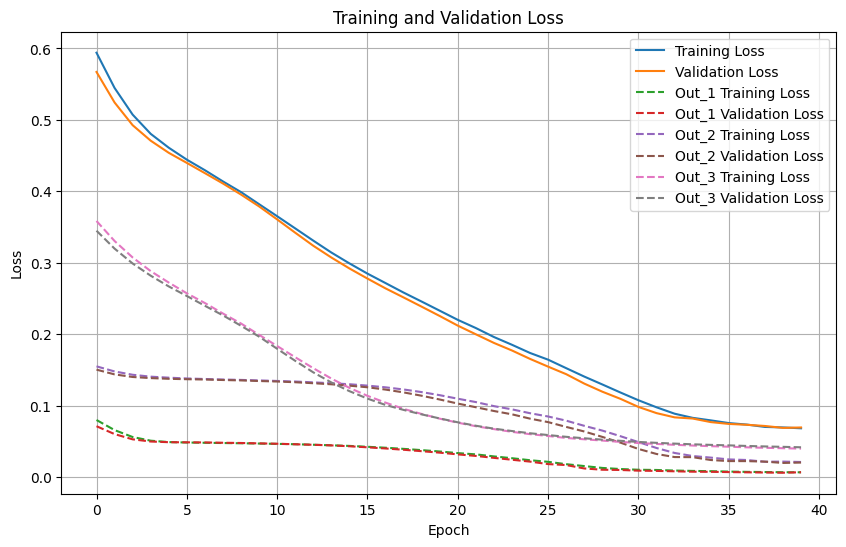

7/7 [==============================] - 1s 5ms/step


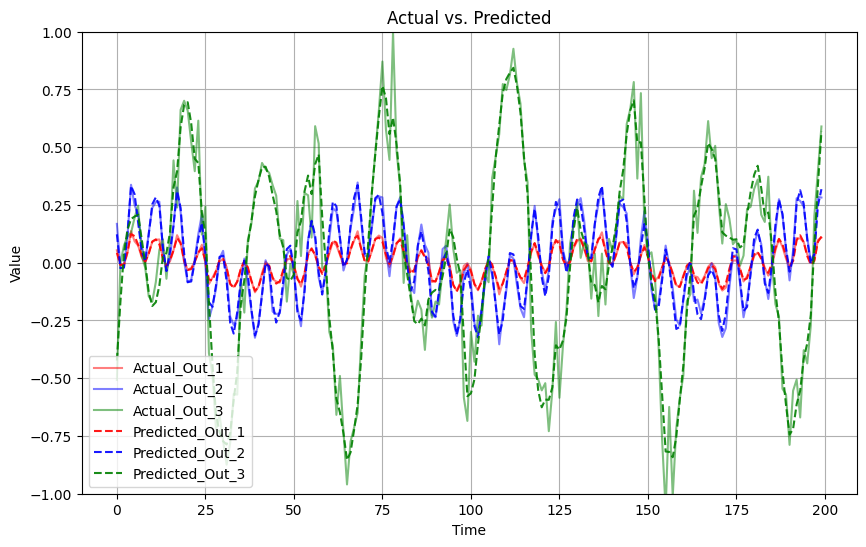

In [ ]:
# @title ####__7.2 Plot Results__

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')

plt.plot(history_GRU.history['output1_loss'], label='Out_1 Training Loss', linestyle='dashed')
plt.plot(history_GRU.history['val_output1_loss'], label='Out_1 Validation Loss', linestyle='dashed')
plt.plot(history_GRU.history['output2_loss'], label='Out_2 Training Loss', linestyle='dashed')
plt.plot(history_GRU.history['val_output2_loss'], label='Out_2 Validation Loss', linestyle='dashed')
plt.plot(history_GRU.history['output3_loss'], label='Out_3 Training Loss', linestyle='dashed')
plt.plot(history_GRU.history['val_output3_loss'], label='Out_3 Validation Loss', linestyle='dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

from keras.models import load_model

def custom_loss1(y_true, y_pred):
    return K.mean(K.abs(y_true[:, 0] - tf.squeeze(y_pred) + 1e-10), axis=-1)

def custom_loss2(y_true, y_pred):
    return K.mean(K.abs(y_true[:, 1] - tf.squeeze(y_pred) + 1e-10), axis=-1)

def custom_loss3(y_true, y_pred):
    loss_3 = (K.mean(K.abs(y_true[:, 2] - tf.squeeze(y_pred) + 1e-10), axis=-1) +
              K.mean(K.square(y_true[:, 2] - tf.squeeze(y_pred) + 1e-10), axis=-1)
              ) / 2
    return loss_3

model = load_model('./MultiOut_model.h5', custom_objects={'custom_loss1': custom_loss1, 'custom_loss2': custom_loss2, 'custom_loss3': custom_loss3})
y_pred_loaded = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual_Out_1', color='red', alpha=0.5)
plt.plot(y_test[:, 1], label='Actual_Out_2', color='blue', alpha=0.5)
plt.plot(y_test[:, 2], label='Actual_Out_3', color='green', alpha=0.5)
plt.plot(y_pred_loaded[0], label='Predicted_Out_1', color='red', linestyle='dashed', alpha=0.9)
plt.plot(y_pred_loaded[1], label='Predicted_Out_2', color='blue', linestyle='dashed', alpha=0.9)
plt.plot(y_pred_loaded[2], label='Predicted_Out_3', color='green', linestyle='dashed', alpha=0.9)
plt.legend(loc='lower left')
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid()
plt.ylim(-1, 1)
plt.show()